In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import astropy.table
import healpy as hp

In [89]:
import flatmaps as fm
import pymaster as nmt

In [112]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [2]:
%matplotlib inline

We are going to read the data catalog that we created in `DC2_matching_and_depth`

In [142]:
data = fitsio.read('/global/projecta/projectdirs/lsst/groups/LSS/DC2_R1.1p/catalog_r1p1.fits.gz')

In [4]:
mask = hp.read_map('/global/projecta/projectdirs/lsst/groups/LSS/DC2_R1.1p/depth_coadd_r.fits.gz')

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [5]:
nz = fitsio.read('/global/projecta/projectdirs/lsst/groups/LSS/DC2_R1.1p/nz_matched_r1p1p.fits.gz')

In [158]:
mi = fm.FlatMapInfo((np.min(np.degrees(data['ra'])),np.max(np.degrees(data['ra']))),(np.min(np.degrees(data['dec'])),np.max(np.degrees(data['dec']))),nx=364,ny=261)

We have to create the depth map for this pixelation scheme

In [16]:
def binned_statistic(x, values, func, nbins, range):
    '''The usage is approximately the same as the scipy one
    from https://stackoverflow.com/questions/26783719/effic
    iently-get-indices-of-histogram-bins-in-python'''
    from scipy.sparse import csr_matrix
    r0, r1 = range
    mask = (x > r0) &  (x < r1)
    x = x[mask]
    values = values[mask]
    N = len(values)
    digitized = (float(nbins) / (r1-r0) * (x-r0)).astype(int)
    S = csr_matrix((values, [digitized, np.arange(N)]), shape=(nbins, N))
    return np.array([func(group) for group in np.split(S.data, S.indptr[1:-1])])

In [159]:
# Code from: https://github.com/LSSTDESC/HyperSupremeStructure-HSC-LSS
def depth_map_snr_nonHP(ra, dec, mags, snr, snrthreshold, flatSkyGrid):
    # not based on healpix, original version modified to use flatmaps
    # also added the functionality to add snr_threshold
    good = np.logical_or(np.logical_not(np.isnan(ra)),np.logical_not(np.isnan(dec)))
    pix_nums = np.array(flatSkyGrid.pos2pix(ra, dec))

    map_out = np.zeros(flatSkyGrid.get_size())
    map_var_out = np.zeros(flatSkyGrid.get_size())
    mask_nans=np.zeros(flatSkyGrid.get_size());

    #Binned statistic 2d is awfully slow (because it doesn't use the fact that all bins are equal width
    #median_snr, xed, _, _ = binned_statistic_2d(mags,pix_nums,snr,statistic='median',bins=(50,12*nside**2),
    #                                           range=[(20,30),(0,12*nside**2)])
    #bin_centers = 0.5*xed[1:]+0.5*xed[:-1]
    #depth = bin_centers[np.argmin(np.fabs(median_snr-5),axis=0)]

    bin_centers = np.linspace(22+6/30.,28-6/30.,30.)
    for px in np.unique(pix_nums):
        mask_nans[px]=1
        mask = px==pix_nums
        if np.count_nonzero(mask)>0:
            median_snr = binned_statistic(mags[mask],snr[mask],np.nanmedian, nbins=30, range=(22,28))
            std_snr = binned_statistic(mags[mask],snr[mask],np.nanstd, nbins=30, range=(22,28))

            mask2 = np.isnan(median_snr)==False
            if np.count_nonzero(mask2)>0:
                depth = bin_centers[mask2][np.argmin(np.fabs(median_snr[mask2]-snrthreshold))]
                std = std_snr[np.argmin(np.fabs(median_snr[mask2]-snrthreshold))]
                map_out[px]=depth
                map_var_out[px]= std
            else:
                map_out[px]=0
                map_var_out[px]= 0
        else:
            map_out[px]=0.
            map_var_out[px]= 0

    map_out[mask_nans<1]=0
    map_var_out[mask_nans<1]=0

    return map_out, map_var_out

def desc_method(ra, dec, band, mags, snr, flatSkyGrid, SNRthreshold= 5):
    # make a histograms of the S/N in bins of magnitude for all objects in a given pixel
    # define the 5 sigma depth as the magnitude of the histogram whose median S/N is ~5.
    # SNRthreshold= 5 => 5sigma depth. can tweak it.

    depth, depth_std= depth_map_snr_nonHP(ra, dec,
                                          mags= mags,
                                          snr= snr,
                                          snrthreshold= SNRthreshold,
                                          flatSkyGrid= flatSkyGrid)

    return depth, depth_std

In [160]:
sel = (data['isprimary'])

In [161]:
# This is slow so I saved one map
#depth_map, depth_std = desc_method(np.degrees(data['ra'][sel]),np.degrees(data['dec'][sel]),'r',data['magmodel'][sel],data['modelflux'][sel]/data['modelflux_err'][sel],mi)

/global/common/cori/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/global/common/cori/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/global/common/cori/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


In [163]:
#mi.write_flat_map('/global/projecta/projectdirs/lsst/groups/LSS/DC2_R1.1p/flatmap_depth_r1p1',depth_map)

We have already one depth map made so, let's read it and use it.

In [148]:
mp, depth_map = fm.read_flat_map('/global/projecta/projectdirs/lsst/groups/LSS/DC2_R1.1p/flatmap_depth_r1p1.npz')

We select objects with good signal to noise and that have `extendedness==1` as galaxies.

In [164]:
mask_flat = depth_map > 25.0
sel = (data['isprimary']) & (data['magmodel']<25.0) & (data['extendedness']==1)

/global/common/cori/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [151]:
def compute_cls(ra,dec,mask,show_plots=True,ncov=0):
    ipix = mi.pos2pix(ra,dec)
    good_ipix = np.in1d(ipix,np.where(mask)[0])
    ipix=ipix[good_ipix]
    mp = np.bincount(ipix,minlength=mi.get_size())
    dmap = np.zeros(len(mp))
    dmap[mask] = mp[mask]/np.mean(mp[mask])-1.
    #Check how these maps look like
    if show_plots:
        plt.figure()
        mi.view_map(dmap*mp)
        plt.figure()
        mi.view_map(mask)
    #Compute Cls
    cl,lbpw,wsp=mi.compute_power_spectrum(dmap*mask,mask)
    ells = np.mean(lbpw,axis=0)
    cl_list = []
    return ells, cl, np.sum(mp[mask])

In [165]:
np.count_nonzero(sel)

1685815

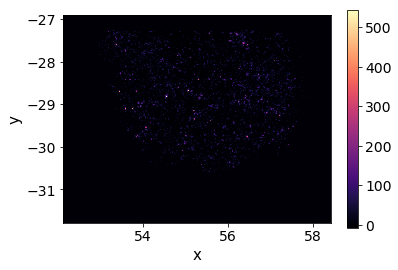

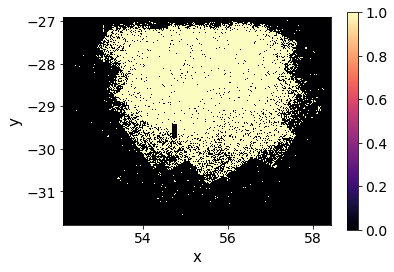

In [166]:
ells_data_tot, cl_data_tot, total_parts = compute_cls(np.degrees(data['ra'][sel]),np.degrees(data['dec'][sel]),mask_flat)

In [167]:
total_area = 4*np.pi*np.count_nonzero(mask>25)/len(mask)

In [168]:
total_area/total_parts

2.998252734197768e-09

In [169]:
errors = 1./np.sqrt(total_area/(4.*np.pi)*(ells_data_tot[1]-ells_data_tot[0]))*cl_data_tot*np.sqrt(2/(2*ells_data_tot+1))+total_area/total_parts

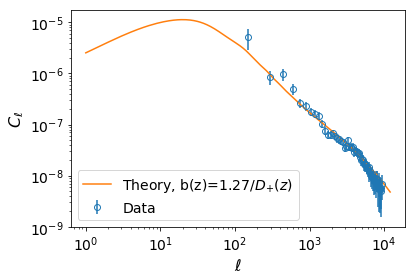

In [170]:
plt.errorbar(ells_data_tot,cl_data_tot-total_area/total_parts,errors,fmt='o',fillstyle='none',label='Data')
plt.loglog(np.arange(12001),cls_th,label='Theory, b(z)=1.27/$D_{+}(z)$')
plt.xlabel('$\ell$',fontsize=16)
plt.ylabel('$C_{\ell}$',fontsize=16)
plt.legend(loc='best')

In [73]:
import h5py
f = h5py.File('/global/projecta/projectdirs/lsst/groups/CS/descqa/catalog/ANL_AlphaQ_v2.1.hdf5')

In [75]:
f['metaData/simulationParameters'].keys()

[u'H_0',
 u'NP',
 u'N_s',
 u'Omega_DE',
 u'Omega_Nu',
 u'Omega_b',
 u'Omega_matter',
 u'boxSize',
 u'haloMassDefinition',
 u'particleMass',
 u'sigma_8',
 u'w_de']

In [78]:
h0 = f['metaData/simulationParameters/H_0'].value/100.
ns = f['metaData/simulationParameters/N_s'].value
w0 = f['metaData/simulationParameters/w_de'].value
sigma8 = f['metaData/simulationParameters/sigma_8'].value
Omega_b = f['metaData/simulationParameters/Omega_b'].value
Omega_c = f['metaData/simulationParameters/Omega_matter'].value-Omega_b
print(Omega_c,Omega_b,sigma8,w0,ns,h0)

(0.21999999999999997, 0.0448, 0.80000000000000004, -1.0, 0.96299999999999997, 0.70999999999999996)


In [37]:
import pyccl as ccl

In [138]:
cosmo = ccl.Cosmology(Omega_c=Omega_c,Omega_b=Omega_b,n_s=ns,sigma8=sigma8,h=h0,w0=w0)

In [139]:
b = 1.27/ccl.growth_factor(cosmo,1/(1+nz['z']))

In [140]:
tracer = ccl.ClTracerNumberCounts(cosmo,True,False,bias=(nz['z'],b),n=(nz['z'],nz['Nz']))

In [141]:
cls_th = ccl.angular_cl(cosmo,tracer,tracer,np.arange(12001))